In [44]:
import matplotlib.pyplot as plt
import numpy
import onnx
import onnxruntime as rt
import pandas as pd
import pickle
import pyomo.environ as pyo
from omlt import OmltBlock
from omlt.gbt import GBTBigMFormulation, GradientBoostedTreeModel

In [45]:
with open("base_score", "r") as f:
    BASE_SCORE = float(f.read())  # Mean value of labeled training data, see previous notebook
print(f"Base score of the gradient-boosted trees: {BASE_SCORE}")

Base score of the gradient-boosted trees: 4363.578666666666


In [46]:
# Example input
data = dict(
    average_speed_kph = [50, 50, 80, 50, 50, 50],
    distance = [2000, 5000, 2000, 2000, 2000, 2000],
    elevation_gain = [0, 0, 0, 100, 0, 0],
    expected_precipitation = [0, 0, 0, 0, 0, 5],
    time_of_departure_min = [12*60, 12*60, 12*60, 12*60, 0, 12*60],
)

X_test = pd.DataFrame.from_dict(data)
X_test

,average_speed_kph,distance,elevation_gain,expected_precipitation,time_of_departure_min
0,50,2000,0,0,720
1,50,5000,0,0,720
2,80,2000,0,0,720
3,50,2000,100,0,720
4,50,2000,0,0,0
5,50,2000,0,5,720


In [47]:
# Read pickled model
with open('model.pkl', 'rb') as f:
    pkl_model = pickle.loads(f.read())

# Read ONNX model
onx_sess = rt.InferenceSession("model.onnx", providers=rt.get_available_providers())


In [48]:
# Predictions from pickle model
y_pkl = pd.Series(pkl_model.predict(X_test), name="Predictions from pickle model")

In [49]:
# Predictions from ONNX model
input_name = onx_sess.get_inputs()[0].name
pred_onx = onx_sess.run(None, {input_name: X_test.to_numpy().astype(numpy.float32)})[0]
y_onx = pd.Series(pred_onx.ravel(), name="Predictions from ONNX model")

In [50]:
onnx_model = onnx.load('model.onnx')
y_opt = []

for _, row in X_test.iterrows():
    input_bounds = {idx: (x, x) for idx, x in enumerate(row)}

    # Create a pyomo model with variables x and y
    opt_model = pyo.ConcreteModel('Random Forest')

    # Import ML-model as OPT-formulation
    opt_model.gbt = OmltBlock()
    gbt_model = GradientBoostedTreeModel(onnx_model, 
                                         scaled_input_bounds=input_bounds)
    
    formulation = GBTBigMFormulation(gbt_model)
    opt_model.gbt.build_formulation(formulation)

    opt_model.obj = pyo.Objective(expr=0)
  
    # opt_model.display()

    # solver = pyo.SolverFactory('cbc')
    solver = pyo.SolverFactory('cbc')
    status = solver.solve(opt_model, tee=False)   
    
    
    # print(f"inputs: {[pyo.value(opt_model.gbt.inputs[i]) for i in range(len(opt_model.gbt.inputs))]}")
    # print(f"outputs: {[pyo.value(opt_model.gbt.outputs[i]) for i in range(len(opt_model.gbt.outputs))]}")
    y_opt.append(opt_model.gbt.outputs[0].value + BASE_SCORE)

y_opt = pd.Series(y_opt, name="Predictions from opt. formulation")

WARNING (W1002): Setting Var 'gbt.scaled_inputs[0]' to a numeric value `0`
    outside the bounds (50, 50).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'gbt.scaled_inputs[0]' to a numeric value `0`
    outside the bounds (50, 50).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'gbt.scaled_inputs[1]' to a numeric value `0`
    outside the bounds (2000, 2000).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'gbt.scaled_inputs[4]' to a numeric value `0`
    outside the bounds (720, 720).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
    solver failure.
WARNING (W1002): Setting Var 'gbt.scaled_inputs[0]' to a numeric value `0`
    outside the bounds (50, 50).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'gbt.scaled_inputs[0]' to a numeric value `0`
    outsi

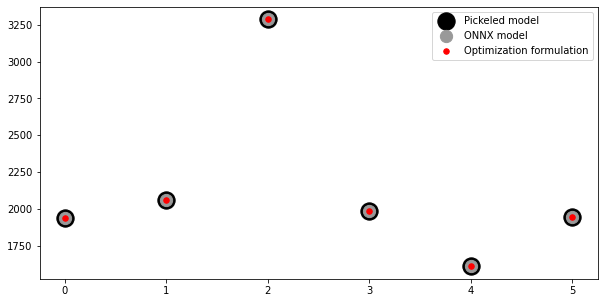

In [58]:
plt.figure(figsize=(10,5))
plt.scatter(y_pkl.index, y_pkl, s=300, color='#000000')
plt.scatter(y_onx.index, y_onx, s=150, color='#999999')
plt.scatter(y_opt.index, y_opt, s=30, color='#FF0000')
plt.legend(['Pickeled model', 'ONNX model', 'Optimization formulation'], )